# Required Libraries : Install only if necessary.

In [1]:
#Uncomment the line below and run that inside this Jupyter notebook to install all the libraries at once, if necessary:

#%pip install numpy pandas matplotlib seaborn plotly dash prophet tqdm ipywidgets jupyter

Installing only Prophet

In [2]:
# Uncomment the line below to install Prophet only:
# #%pip install prophet

# UK BEV cars baseline sales forecast till 2040

In [3]:
from prophet import Prophet
import pandas as pd
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")


df_bev = pd.read_csv('BEV_dataset.csv')
df_bev.rename(columns={'Quarter': 'ds', 'BEV_Sales': 'y'}, inplace=True)

df_bev['ds'] = pd.PeriodIndex(df_bev['ds'], freq='Q').to_timestamp(how='end')


model_bev = Prophet()
model_bev.fit(df_bev)

#4 quarters=1 year
future_bev = model_bev.make_future_dataframe(periods=68, freq='QE')
forecast_bev = model_bev.predict(future_bev)
forecast_bev['ds'] = forecast_bev['ds'] + pd.offsets.QuarterEnd(0)

fig_bev = go.Figure()
fig_bev.add_trace(go.Scatter(x=forecast_bev['ds'], y=forecast_bev['yhat'],
                             name='Forecast', line=dict(color='blue')))
fig_bev.add_trace(go.Scatter(x=df_bev['ds'], y=df_bev['y'],
                             name='Historical BEV Sales', mode='markers', marker=dict(color='black')))
fig_bev.add_trace(go.Scatter(x=forecast_bev['ds'], y=forecast_bev['yhat_upper'],
                             name='Upper Bound', line=dict(dash='dot', color='lightblue')))
fig_bev.add_trace(go.Scatter(x=forecast_bev['ds'], y=forecast_bev['yhat_lower'],
                             name='Lower Bound', line=dict(dash='dot', color='lightblue')))

fig_bev.update_layout(
    title='UK Baseline BEV Sales Forecast',
    xaxis_title='Quarter',
    yaxis_title='BEV Sales',
    template='plotly_white',
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey')
)

fig_bev.show()


16:20:04 - cmdstanpy - INFO - Chain [1] start processing
16:20:05 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
last_date = df_bev['ds'].max()
print("Last historic data point:", last_date)
bev_future = forecast_bev[forecast_bev['ds'] > last_date].copy()
def date_to_quarter(date):
    q = (date.month - 1) // 3 + 1
    return f"{date.year}Q{q}"

bev_future['Quarter'] = bev_future['ds'].apply(date_to_quarter)

bev_future = bev_future[['Quarter', 'yhat']].rename(columns={'yhat': 'Value'})
bev_future['Metric'] = "BEV Car Sales"
bev_future['Scenario'] = "Baseline"

# Saving to CSV : 
# Uncomment the block of code ( remove the quotes ) below to save the forecasted values to a csv. The csv has already been uploaded to the submission folders 

"""bev_future.to_csv("Forecast_BEV_Cars_2025_2040.csv", index=False)
print(bev_future.head())
print("BEV forecast saved: Forecast_BEV_Cars_2025_2040.csv")"""

Last historic data point: 2024-12-31 23:59:59.999999999


'bev_future.to_csv("Forecast_BEV_Cars_2025_2040.csv", index=False)\nprint(bev_future.head())\nprint("BEV forecast saved: Forecast_BEV_Cars_2025_2040.csv")'

In [5]:
forecast_bev['ds'] = pd.to_datetime(forecast_bev['ds'])

def extract_year_summary(forecast_bev, year):
    year_q4 = forecast_bev[
        (forecast_bev['ds'].dt.year == year) & (forecast_bev['ds'].dt.quarter == 4)
    ]
    
    if not year_q4.empty:
        row = year_q4.iloc[0]
        print(f"  Forecast Summary for {year} Q4  ")
        print(f"Predicted BEV Sales (yhat): {row['yhat']:.0f}")
        print(f"Lower Bound (yhat_lower): {row['yhat_lower']:.0f}")
        print(f"Upper Bound (yhat_upper): {row['yhat_upper']:.0f}")
        print("---------------------------------------\n")
    else:
        print(f"No Q4 forecast found for year {year}\n")

extract_year_summary(forecast_bev, 2030)
extract_year_summary(forecast_bev, 2035)
extract_year_summary(forecast_bev, 2040)


  Forecast Summary for 2030 Q4  
Predicted BEV Sales (yhat): 204847
Lower Bound (yhat_lower): 189727
Upper Bound (yhat_upper): 219791
---------------------------------------

  Forecast Summary for 2035 Q4  
Predicted BEV Sales (yhat): 282948
Lower Bound (yhat_lower): 245867
Upper Bound (yhat_upper): 317920
---------------------------------------

  Forecast Summary for 2040 Q4  
Predicted BEV Sales (yhat): 374011
Lower Bound (yhat_lower): 310799
Upper Bound (yhat_upper): 433880
---------------------------------------



--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Charger-driven BEV Sales Forecast

In [6]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objects as go
 
df = pd.read_csv("EVvsChargerdataset_corranalysis.csv")

import warnings
warnings.filterwarnings("ignore")

df.rename(columns={
    "Quarter": "ds",
    "BEV_Sales": "y",
    "Total Charging Devices": "chargers"
}, inplace=True)

df["ds"] = pd.to_datetime(df["ds"])

m = Prophet(yearly_seasonality=True)
m.add_regressor("chargers")

m.fit(df[["ds", "y", "chargers"]])

future = m.make_future_dataframe(periods=68, freq="QE")  # 16 years ahead (to 2040)
future = future.merge(df[["ds", "chargers"]], on="ds", how="left")
future["chargers"] = future["chargers"].ffill()

forecast = m.predict(future)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df["ds"], y=df["y"],
    mode="markers", name="Historical BEV Sales",
    marker=dict(color="black")
))

fig.add_trace(go.Scatter(
    x=forecast["ds"], y=forecast["yhat"],
    mode="lines", name="Forecast",
    line=dict(color="blue")
))

fig.add_trace(go.Scatter(
    x=forecast["ds"], y=forecast["yhat_upper"],
    mode="lines", name="Upper Bound",
    line=dict(dash="dot", color="lightblue")
))
fig.add_trace(go.Scatter(
    x=forecast["ds"], y=forecast["yhat_lower"],
    mode="lines", name="Lower Bound",
    line=dict(dash="dot", color="lightblue")
))

fig.update_layout(
    title="Forecast of BEV Sales Using Charger Growth as Sole Regressor",
    xaxis_title="Quarter",
    yaxis_title="BEV Sales",
    template="plotly_white"
)

fig.show()

milestones = forecast[forecast["ds"].dt.year.isin([2030, 2035, 2040])]
milestone_summary = (
    milestones.groupby(milestones["ds"].dt.year)
    .tail(1)[["ds", "yhat", "yhat_lower", "yhat_upper"]]
    .round(0)
)
print(milestone_summary.to_string(index=False))


16:20:09 - cmdstanpy - INFO - Chain [1] start processing
16:20:09 - cmdstanpy - INFO - Chain [1] done processing


        ds     yhat  yhat_lower  yhat_upper
2030-12-31 373279.0    367076.0    379555.0
2035-12-31 613513.0    607050.0    619455.0
2040-12-31 865319.0    859000.0    871198.0


In [7]:
"""def date_to_quarter(date):
    q = (date.month - 1)//3 + 1
    return f"{date.year}Q{q}"

out = forecast[["ds","yhat"]].copy()
out["Quarter"] = out["ds"].apply(date_to_quarter)
out = out[out["ds"] > df["ds"].max()]
out.rename(columns={"yhat":"Value"}, inplace=True)
out["Metric"] = "BEV Cars"
out["Scenario"] = "ChargerDriven"

out.to_csv("Forecast_BEVCars_ChargerDriven.csv", index=False)
print("Saved to Forecast_BEVCars_ChargerDriven.csv")"""


'def date_to_quarter(date):\n    q = (date.month - 1)//3 + 1\n    return f"{date.year}Q{q}"\n\nout = forecast[["ds","yhat"]].copy()\nout["Quarter"] = out["ds"].apply(date_to_quarter)\nout = out[out["ds"] > df["ds"].max()]\nout.rename(columns={"yhat":"Value"}, inplace=True)\nout["Metric"] = "BEV Cars"\nout["Scenario"] = "ChargerDriven"\n\nout.to_csv("Forecast_BEVCars_ChargerDriven.csv", index=False)\nprint("Saved to Forecast_BEVCars_ChargerDriven.csv")'

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Battery-Price Driven BEV sales forecast

In [8]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("Merged_Battery_and_BEVsales.csv")
df['Quarter'] = pd.to_datetime(df['Quarter'], errors='coerce')
df = df.rename(columns={'Quarter': 'ds', 'BEV_Sales': 'y'})
df = df[['ds', 'y', 'Battery Price (GBP/kWh)']]

train_df = df[df['y'].notna()]

model = Prophet()
model.add_regressor('Battery Price (GBP/kWh)')
model.fit(train_df)

future_periods = pd.date_range(start=df['ds'].max(), periods=64, freq='QE')  
last_known_regressor = df[['ds', 'Battery Price (GBP/kWh)']].dropna()
future_regressors = last_known_regressor.iloc[-1:].copy()

future_data = pd.DataFrame({'ds': future_periods})
future_data['Battery Price (GBP/kWh)'] = future_regressors['Battery Price (GBP/kWh)'].values[0]

historical = df[['ds', 'Battery Price (GBP/kWh)']]
future_full = pd.concat([historical, future_data], ignore_index=True)

forecast = model.predict(future_full)


import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat'],
    mode='lines', name='Forecasted BEV Sales',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=train_df['ds'], y=train_df['y'],
    mode='markers', name='Actual BEV Sales',
    marker=dict(color='black', size=6)
))

fig.update_layout(
    title='Forecasted BEV Sales Using Battery Prices (to 2040)',
    xaxis_title='Date',
    yaxis_title='BEV Sales (Quarterly)',
    legend_title='Legend',
    template='plotly_white',
    height=600,
    width=1000
)

fig.show()


16:20:09 - cmdstanpy - INFO - Chain [1] start processing
16:20:10 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
#Extractinng the forecasts
forecast_selected_years = forecast[forecast['ds'].dt.year.isin([2030, 2035, 2040])][
    ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
]

print("Quarterly Forecasted BEV Sales for 2030, 2035, and 2040:")
print(forecast_selected_years)


Quarterly Forecasted BEV Sales for 2030, 2035, and 2040:
            ds           yhat     yhat_lower     yhat_upper
61  2030-03-31  276871.898874  268300.352062  284858.484567
62  2030-06-30  290624.493876  282370.538604  299097.150945
63  2030-09-30  260885.010102  252655.944293  268888.907373
64  2030-12-31  309752.112220  300813.217652  318009.055971
81  2035-03-31  366645.420132  358460.974248  374362.395316
82  2035-06-30  387546.798961  379402.515142  396038.742808
83  2035-09-30  341871.613539  333376.510621  349825.216073
84  2035-12-31  407435.085740  399202.160886  416068.138135
101 2040-03-31  475061.198664  466274.921121  483519.715402
102 2040-06-30  480505.292851  472280.601419  488963.744042
103 2040-09-30  474216.336193  466315.848636  482042.504125
104 2040-12-31  497438.121329  489069.678679  505445.541821


In [10]:

#Uncomment the block of code (remove the quotes) below for saving the forecasts to a CSV. If has already been provided in the submission files


"""def date_to_quarter(date):
    q = (date.month - 1)//3 + 1
    return f"{date.year}Q{q}"

out = forecast[["ds","yhat"]].copy()
out["Quarter"] = out["ds"].apply(date_to_quarter)
out = out[out["ds"] > train_df["ds"].max()] 
out.rename(columns={"yhat":"Value"}, inplace=True)
out["Metric"] = "BEV Cars"
out["Scenario"] = "BatteryDriven"

out.to_csv("Forecast_BEVCars_BatteryDriven.csv", index=False)
print("Saved to Forecast_BEVCars_BatteryDriven.csv")"""


'def date_to_quarter(date):\n    q = (date.month - 1)//3 + 1\n    return f"{date.year}Q{q}"\n\nout = forecast[["ds","yhat"]].copy()\nout["Quarter"] = out["ds"].apply(date_to_quarter)\nout = out[out["ds"] > train_df["ds"].max()] \nout.rename(columns={"yhat":"Value"}, inplace=True)\nout["Metric"] = "BEV Cars"\nout["Scenario"] = "BatteryDriven"\n\nout.to_csv("Forecast_BEVCars_BatteryDriven.csv", index=False)\nprint("Saved to Forecast_BEVCars_BatteryDriven.csv")'

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# BEV Cars Sales Forecast with the 2021 Net-Zero Strategy Announcement

In [11]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

df_bev = pd.read_csv("BEV_dataset.csv")
df_bev = df_bev.rename(columns={"Quarter": "ds", "BEV_Sales": "y"})
df_bev["ds"] = pd.to_datetime(df_bev["ds"])


#Policy regressors
df_bev["policy_signal_2021"] = (df_bev["ds"] >= "2021-11-01").astype(int)


for c in ["policy_signal_2021"]:
    df_bev[c] = df_bev[c] - df_bev[c].mean()

m = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.5 
)

m.add_regressor("policy_signal_2021")


m.fit(df_bev)

future = m.make_future_dataframe(periods=68, freq="QE")  

f = future.copy()
f["policy_signal_2021_raw"] = (f["ds"] >= "2021-11-01").astype(int)

means = {
    "policy_signal_2021": df_bev["policy_signal_2021"].mean() + 0,  
    }

future["policy_signal_2021"] = f["policy_signal_2021_raw"] - means["policy_signal_2021"]


forecast = m.predict(future)


forecast_out = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_bev['ds'], y=df_bev['y'],
    mode='markers', name='Observed (history)',
    marker=dict(size=7, opacity=1.0, color='black')
))

fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat"],       name="Forecast"))
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat_lower"], name="Lower Bound", line=dict(dash="dot")))
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat_upper"], name="Upper Bound", line=dict(dash="dot")))
fig.update_layout(
    title="BEV Sales Forecast with 2021 Net Zero Strategy (policy announcement)",
    xaxis_title="Date", yaxis_title="BEV Sales"
)
fig.show()


target_years = [2030, 2035, 2040]
sel = (
    forecast.assign(year=forecast["ds"].dt.year)
            [forecast["ds"].dt.year.isin(target_years)]
            .sort_values("ds")
            .groupby("year")
            .tail(1)[["ds","yhat","yhat_lower","yhat_upper"]]
            .round(0)
)
print(sel.to_string(index=False))


16:20:10 - cmdstanpy - INFO - Chain [1] start processing
16:20:11 - cmdstanpy - INFO - Chain [1] done processing


        ds     yhat  yhat_lower  yhat_upper
2030-12-31 190351.0    166165.0    214536.0
2035-12-31 263483.0    207281.0    319153.0
2040-12-31 346837.0    251961.0    446120.0


In [12]:
#Uncomment the block of code to save the forecasts to a CSV. However, all the CSVs have been provided in the submission files

"""def date_to_quarter(date):
    q = (date.month - 1)//3 + 1
    return f"{date.year}Q{q}"

out = forecast[["ds","yhat"]].copy()
out["Quarter"] = out["ds"].apply(date_to_quarter)
out = out[out["ds"] > df_bev["ds"].max()]  # only future
out.rename(columns={"yhat":"Value"}, inplace=True)
out["Metric"] = "BEV Cars"
out["Scenario"] = "Policy2021"

out.to_csv("Forecast_BEVCars_Policy2021.csv", index=False)
print("Forecasts saved to Forecast_BEVCars_Policy2021.csv")"""


'def date_to_quarter(date):\n    q = (date.month - 1)//3 + 1\n    return f"{date.year}Q{q}"\n\nout = forecast[["ds","yhat"]].copy()\nout["Quarter"] = out["ds"].apply(date_to_quarter)\nout = out[out["ds"] > df_bev["ds"].max()]  # only future\nout.rename(columns={"yhat":"Value"}, inplace=True)\nout["Metric"] = "BEV Cars"\nout["Scenario"] = "Policy2021"\n\nout.to_csv("Forecast_BEVCars_Policy2021.csv", index=False)\nprint("Forecasts saved to Forecast_BEVCars_Policy2021.csv")'

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# BEV Sales forecasting with the 2024 policy and the 2025 £3,750 Electric Car Grant

In [13]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objects as go

df_bev = pd.read_csv('BEV_dataset.csv') 
df_bev.rename(columns={'Quarter': 'ds', 'BEV_Sales': 'y'}, inplace=True)
df_bev['ds'] = pd.to_datetime(df_bev['ds'])

import warnings
warnings.filterwarnings("ignore")

df_bev['uk_2024_mandate'] = (df_bev['ds'] >= '2024-01-01').astype(int)

df_bev['grant_2025_policy'] = (df_bev['ds'] >= '2025-07-15').astype(int)

model = Prophet()
model.add_regressor('uk_2024_mandate')
model.add_regressor('grant_2025_policy')
model.fit(df_bev)

future = model.make_future_dataframe(periods=68, freq='QE') 

# Adding regressors to future df
future['uk_2024_mandate'] = (future['ds'] >= '2024-01-01').astype(int)
future['grant_2025_policy'] = (future['ds'] >= '2025-07-15').astype(int)

forecast = model.predict(future)

fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Forecast'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], name='Lower Bound', line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], name='Upper Bound', line=dict(dash='dot')))
fig.update_layout(title='BEV Sales Forecast with Dual Policy Regressors - 2024 mandate and the 2025 Electric Car grant',
                  xaxis_title='Date', yaxis_title='BEV Sales')
fig.show()


16:20:11 - cmdstanpy - INFO - Chain [1] start processing
16:20:12 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
import pandas as pd

target_years = [2030, 2035, 2040]

forecast = forecast.copy()
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['year'] = forecast['ds'].dt.year

milestones = (
    forecast[forecast['year'].isin(target_years)]
      .sort_values('ds')
      .groupby('year')
      .tail(1)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
      .round({'yhat': 0, 'yhat_lower': 0, 'yhat_upper': 0})
      .rename(columns={
          'ds': 'Quarter',
          'yhat': 'Forecast',
          'yhat_lower': 'Lower_Bound',
          'yhat_upper': 'Upper_Bound'
      })
      .reset_index(drop=True)
)

print(milestones.to_string(index=False))



   Quarter  Forecast  Lower_Bound  Upper_Bound
2030-12-31  200086.0     183782.0     215787.0
2035-12-31  281320.0     246308.0     317557.0
2040-12-31  374017.0     310258.0     434253.0


In [15]:
#Uncomment the block of code(remove the quotes) below for saving the forecasts to a CSV. It has already been provided in the submission folders
"""def date_to_quarter(date):
    q = (date.month - 1)//3 + 1
    return f"{date.year}Q{q}"

out = forecast[["ds","yhat"]].copy()
out["Quarter"] = out["ds"].apply(date_to_quarter)
out = out[out["ds"] > df_bev["ds"].max()]
out.rename(columns={"yhat":"Value"}, inplace=True)
out["Metric"] = "BEV Cars"
out["Scenario"] = "Policy2024_2025"

out.to_csv("Forecast_BEVCars_Policy2024_2025.csv", index=False)
print("Saved to Forecast_BEVCars_Policy2024_2025.csv")"""


'def date_to_quarter(date):\n    q = (date.month - 1)//3 + 1\n    return f"{date.year}Q{q}"\n\nout = forecast[["ds","yhat"]].copy()\nout["Quarter"] = out["ds"].apply(date_to_quarter)\nout = out[out["ds"] > df_bev["ds"].max()]\nout.rename(columns={"yhat":"Value"}, inplace=True)\nout["Metric"] = "BEV Cars"\nout["Scenario"] = "Policy2024_2025"\n\nout.to_csv("Forecast_BEVCars_Policy2024_2025.csv", index=False)\nprint("Saved to Forecast_BEVCars_Policy2024_2025.csv")'

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Comparing the 2 scenarios

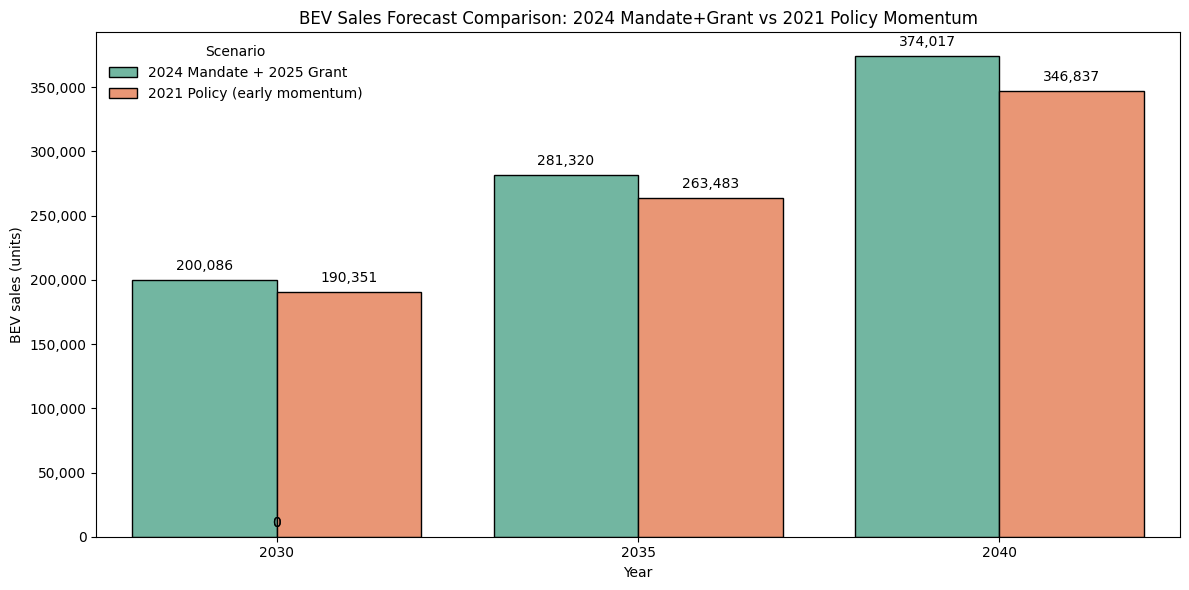

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("BEV_Forecast_Comparison.csv")

plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=df, x="Year", y="Forecast", hue="Scenario",
    palette="Set2", edgecolor="black"
)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=10, xytext=(0,5),
                textcoords="offset points")

ax.set_ylabel("BEV sales (units)")
ax.set_title("BEV Sales Forecast Comparison: 2024 Mandate+Grant vs 2021 Policy Momentum")
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))
plt.legend(title="Scenario", frameon=False)
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Baseline Charger Infrastructure Forecast

In [17]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objects as go

warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

df = pd.read_csv('Quarterly_Charging_Devices.csv')

def quarter_to_date(q_str):
    if 'Q' in q_str:
        year_part, quarter_part = q_str.replace(" ", "").split("Q")
        month = {'1': '01', '2': '04', '3': '07', '4': '10'}.get(quarter_part, '01')
        return pd.to_datetime(f"{year_part}-{month}-01")
    else:
        return pd.NaT

df['ds'] = df['Quarter'].apply(quarter_to_date)
df['y'] = df['Total Charging Devices']
df = df[['ds', 'y']]

model = Prophet()
model.fit(df)

future = model.make_future_dataframe(periods=64, freq='QE')
forecast = model.predict(future)

forecast['ds'] = forecast['ds'].dt.to_period('Q').dt.start_time
df['ds'] = df['ds'].dt.to_period('Q').dt.start_time

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    name='Forecasted Chargers',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_upper'],
    name='Upper Bound',
    line=dict(dash='dot', color='lightblue'),
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_lower'],
    name='Lower Bound',
    line=dict(dash='dot', color='lightblue'),
    fill='tonexty',
    fillcolor='rgba(173, 216, 230, 0.2)',
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=df['ds'],
    y=df['y'],
    mode='markers',
    name='Historical Chargers',
    marker=dict(color='black')
))

fig.update_layout(
    title='Forecasted Quarterly UK Public Charging Devices without any regressors',
    xaxis_title='Years',
    yaxis_title='Total Charger Count',
    template='plotly_white',
    width=1050,
    height=520,
    legend=dict(
        x=1.05,
        y=1,
        bordercolor='black',
        borderwidth=0.5
    )
)

fig.show()


16:20:21 - cmdstanpy - INFO - Chain [1] start processing
16:20:23 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
#extracting the forecasts
forecast['ds'] = pd.to_datetime(forecast['ds'])

def extract_q4_forecast(forecast_df, year):
    q4_date = pd.to_datetime(f"{year}-10-01")
    row = forecast_df[forecast_df['ds'] == q4_date]
    
    if not row.empty:
        row = row.iloc[0]
        print(f"--- Forecast Summary for {year} Q4 ---")
        print(f"Predicted Chargers (yhat): {row['yhat']:.0f}")
        print(f"Lower Bound (yhat_lower): {row['yhat_lower']:.0f}")
        print(f"Upper Bound (yhat_upper): {row['yhat_upper']:.0f}")
        print("-" * 40 + "\n")
    else:
        print(f"No Q4 forecast found for {year}.")

for y in [2030, 2035, 2040]:
    extract_q4_forecast(forecast, y)


--- Forecast Summary for 2030 Q4 ---
Predicted Chargers (yhat): 135419
Lower Bound (yhat_lower): 56953
Upper Bound (yhat_upper): 218196
----------------------------------------

--- Forecast Summary for 2035 Q4 ---
Predicted Chargers (yhat): 182719
Lower Bound (yhat_lower): -37106
Upper Bound (yhat_upper): 392134
----------------------------------------

--- Forecast Summary for 2040 Q4 ---
Predicted Chargers (yhat): 232873
Lower Bound (yhat_lower): -163811
Upper Bound (yhat_upper): 598001
----------------------------------------



In [19]:
#Uncomment ( remove the quotes ) to save to a CSV. All required csvs have been provided in the submission folders.

"""output = forecast[['ds', 'yhat']].copy()
output.rename(columns={'ds': 'Quarter', 'yhat': 'chargers_forecasted'}, inplace=True)
output['Quarter'] = output['Quarter'].dt.to_period('Q').astype(str)
output['Metric'] = "Chargers - Baseline Forecast"
output.to_csv("Forecast_Chargers_Baseline.csv", index=False)
print("Baseline charger forecast saved as Forecast_Chargers_Baseline.csv")"""


'output = forecast[[\'ds\', \'yhat\']].copy()\noutput.rename(columns={\'ds\': \'Quarter\', \'yhat\': \'chargers_forecasted\'}, inplace=True)\noutput[\'Quarter\'] = output[\'Quarter\'].dt.to_period(\'Q\').astype(str)\noutput[\'Metric\'] = "Chargers - Baseline Forecast"\noutput.to_csv("Forecast_Chargers_Baseline.csv", index=False)\nprint("Baseline charger forecast saved as Forecast_Chargers_Baseline.csv")'

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Forecasting Charger statistics with BEV sales and policy(2022) as regressors, and the Government target of 300k chargers

In [20]:
from prophet import Prophet
import pandas as pd
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

df_regressors = pd.read_csv('EVvsChargerdataset_corranalysis.csv')
df_regressors.rename(columns={
    'Quarter': 'ds',
    'BEV_Sales': 'bev_sales',
    'Total Charging Devices': 'chargers'
}, inplace=True)
df_regressors['ds'] = pd.to_datetime(df_regressors['ds'])

#policy dummy (0 before 2022, 1 after)
df_regressors['policy_dummy'] = (df_regressors['ds'] >= '2022-01-01').astype(int)
df_charger_prophet = df_regressors.rename(columns={'chargers': 'y'})

model = Prophet()
model.add_regressor('bev_sales')
model.add_regressor('policy_dummy')
model.fit(df_charger_prophet)

#68 periods means 17 years 
future = model.make_future_dataframe(periods=68, freq='QE')
future = future.merge(df_regressors[['ds', 'bev_sales']], on='ds', how='left')
future['bev_sales'] = future['bev_sales'].ffill().bfill()
future['policy_dummy'] = (future['ds'] >= '2022-01-01').astype(int)


forecast = model.predict(future)
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat'],
    mode='lines', name='Forecast',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=df_charger_prophet['ds'], y=df_charger_prophet['y'],
    mode='markers', name='Historical Chargers',
    marker=dict(color='black')
))

#upper and lower confidence intervals
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_upper'],
    mode='lines', name='Upper Bound',
    line=dict(dash='dot', color='lightblue')
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_lower'],
    mode='lines', name='Lower Bound',
    line=dict(dash='dot', color='lightblue')
))

#adding the government target line
fig.add_trace(go.Scatter(
    x=[pd.to_datetime('2030-01-01'), pd.to_datetime('2040-01-01')],
    y=[300000, 300000],
    mode='lines', name='Govt Target: 300,000 by 2030',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Forecast with Regressors: UK Public Charging Infrastructure',
    xaxis_title='Quarter',
    yaxis_title='Total Chargers',
    template='plotly_white',
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()




16:20:23 - cmdstanpy - INFO - Chain [1] start processing
16:20:24 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
forecast['ds'] = pd.to_datetime(forecast['ds'])

def extract_year_summary(forecast_df, year):
    year_q4 = forecast_df[
        (forecast_df['ds'].dt.year == year) & (forecast_df['ds'].dt.quarter == 4)
    ]
    
    if not year_q4.empty:
        row = year_q4.iloc[0]
        print(f"   Forecast Summary for {year} Q4   ")
        print(f"Predicted Chargers (yhat): {row['yhat']:.0f}")
        print(f"Lower Bound (yhat_lower): {row['yhat_lower']:.0f}")
        print(f"Upper Bound (yhat_upper): {row['yhat_upper']:.0f}")
        print("---------------------------------------\n")
    else:
        print(f"No Q4 forecast found for year {year}\n")

#summaries for 2030, 2035, and 2040
extract_year_summary(forecast, 2030)
extract_year_summary(forecast, 2035)
extract_year_summary(forecast, 2040)


   Forecast Summary for 2030 Q4   
Predicted Chargers (yhat): 203309
Lower Bound (yhat_lower): 173718
Upper Bound (yhat_upper): 232949
---------------------------------------

   Forecast Summary for 2035 Q4   
Predicted Chargers (yhat): 306577
Lower Bound (yhat_lower): 236162
Upper Bound (yhat_upper): 379490
---------------------------------------

   Forecast Summary for 2040 Q4   
Predicted Chargers (yhat): 365486
Lower Bound (yhat_lower): 241463
Upper Bound (yhat_upper): 491452
---------------------------------------



In [22]:
#Uncomment the block of code below to save the forecasts to a CSV. However, all the required files have already been uploaded to the submission folders 

"""output = forecast[['ds', 'yhat']].copy()
output.rename(columns={'ds': 'Quarter', 'yhat': 'Value'}, inplace=True)
output['Quarter'] = output['Quarter'].dt.to_period('Q').astype(str)


output['Metric'] = "Chargers - Policy-Driven Forecast"
output.to_csv("Forecast_Chargers_Policy.csv", index=False)
print("Policy-driven charger forecast saved as Forecast_Chargers_Policy.csv")"""


'output = forecast[[\'ds\', \'yhat\']].copy()\noutput.rename(columns={\'ds\': \'Quarter\', \'yhat\': \'Value\'}, inplace=True)\noutput[\'Quarter\'] = output[\'Quarter\'].dt.to_period(\'Q\').astype(str)\n\n\noutput[\'Metric\'] = "Chargers - Policy-Driven Forecast"\noutput.to_csv("Forecast_Chargers_Policy.csv", index=False)\nprint("Policy-driven charger forecast saved as Forecast_Chargers_Policy.csv")'

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# BEV Vans Sales forecast till 2040

In [23]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objs as go

import warnings
warnings.filterwarnings("ignore")

bev_df = pd.read_csv("Van_BEV_quarterly.csv")

bev_df.rename(columns={"Quarter": "ds", "BEV_Sales": "y"}, inplace=True)

bev_df["ds"] = pd.to_datetime(bev_df["ds"])

bev_model = Prophet()
bev_model.fit(bev_df)
future_bev = bev_model.make_future_dataframe(periods=68, freq="QE")
forecast_bev = bev_model.predict(future_bev)


fig_bev = go.Figure()

fig_bev.add_trace(go.Scatter(
    x=bev_df["ds"], y=bev_df["y"],
    mode="markers", name="Actual BEV Vans"
))

fig_bev.add_trace(go.Scatter(
    x=forecast_bev["ds"], y=forecast_bev["yhat"],
    mode="lines", name="Forecasted BEV Vans"
))

fig_bev.update_layout(
    title="Forecasted UK BEV Van Sales to 2040",
    xaxis_title="Date", yaxis_title="Quarterly Sales",
    legend_title="Legend"
)

fig_bev.show()


16:20:24 - cmdstanpy - INFO - Chain [1] start processing
16:20:24 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
#Uncomment (remove the quotes) to save the full forecast to a CSV. However, all the required files have been added to the submission files)
"""def date_to_quarter(date):
    q = (date.month - 1) // 3 + 1
    return f"{date.year}Q{q}"

forecast_bev['Quarter'] = forecast_bev['ds'].apply(date_to_quarter)

bev_vans_future = forecast_bev[forecast_bev['Quarter'] > "2024Q4"].copy()

bev_vans_future = bev_vans_future[['Quarter', 'yhat']].rename(columns={'yhat': 'Value'})
bev_vans_future['Metric'] = "BEV Van Sales"
bev_vans_future['Scenario'] = "Baseline"

bev_vans_future.to_csv("Forecast_BEVVans_2025_2040.csv", index=False)

print(bev_vans_future.head())
print("Forecast CSV saved - Forecast_BEVVans_2025_2040.csv")"""


'def date_to_quarter(date):\n    q = (date.month - 1) // 3 + 1\n    return f"{date.year}Q{q}"\n\nforecast_bev[\'Quarter\'] = forecast_bev[\'ds\'].apply(date_to_quarter)\n\nbev_vans_future = forecast_bev[forecast_bev[\'Quarter\'] > "2024Q4"].copy()\n\nbev_vans_future = bev_vans_future[[\'Quarter\', \'yhat\']].rename(columns={\'yhat\': \'Value\'})\nbev_vans_future[\'Metric\'] = "BEV Van Sales"\nbev_vans_future[\'Scenario\'] = "Baseline"\n\nbev_vans_future.to_csv("Forecast_BEVVans_2025_2040.csv", index=False)\n\nprint(bev_vans_future.head())\nprint("Forecast CSV saved - Forecast_BEVVans_2025_2040.csv")'

In [25]:
# Extract forecasted BEV van sales for 2030, 2035, and 2040
forecast_bev_filtered = forecast_bev[
    forecast_bev['ds'].dt.year.isin([2030, 2035, 2040])
][['ds', 'yhat']]

print("Forecasted Quarterly BEV Van Sales (2030, 2035, 2040):")
print(forecast_bev_filtered.to_string(index=False))


Forecasted Quarterly BEV Van Sales (2030, 2035, 2040):
        ds         yhat
2030-03-31 10140.558651
2030-06-30 10634.722922
2030-09-30  9630.399952
2030-12-31 10047.193339
2035-03-31 13747.517251
2035-06-30 14321.413635
2035-09-30 12820.348730
2035-12-31 13431.017887
2040-03-31 16201.599413
2040-06-30 16629.512798
2040-09-30 16523.096830
2040-12-31 16574.442030


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# ICE sales forecast till 2040 with fuel price and 2030 ban as regressors

In [26]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("ICE_with_fuel.csv")
df.rename(columns={'Quarter':'ds', 'ICE_Sales':'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])

# Add fuel price regressor
df['fuel_price'] = df[['Petrol_Price_ppl', 'Diesel_Price_ppl']].mean(axis=1)

# Add 2030 policy regressor (0 before 2030, 1 from 2030 onwards)
df['policy_2030'] = (df['ds'] >= "2030-01-01").astype(int)

# Prophet model with logistic decline
df['cap'] = df['y'].max()
model = Prophet(growth="logistic", seasonality_mode="multiplicative")
model.add_regressor('fuel_price')
model.add_regressor('policy_2030')

# Fit
model.fit(df)

# Future dataframe till 2040
future = model.make_future_dataframe(periods=68, freq="QE")
future['cap'] = df['cap'].max()
future['fuel_price'] = df['fuel_price'].iloc[-1]  # extend fuel
future['policy_2030'] = (future['ds'] >= "2030-01-01").astype(int)

# Forecast
forecast = model.predict(future)

# Plot
import plotly.graph_objects as go

# Create Plotly figure
fig = go.Figure()

# Historical data
fig.add_trace(go.Scatter(
    x=df['ds'], y=df['y'], 
    mode='lines+markers', 
    name='Historical',
    line=dict(color='black')
))

# Forecast line
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat'],
    mode='lines',
    name='Forecast',
    line=dict(color='blue')
))

# Uncertainty interval
fig.add_trace(go.Scatter(
    x=pd.concat([forecast['ds'], forecast['ds'][::-1]]),
    y=pd.concat([forecast['yhat_upper'], forecast['yhat_lower'][::-1]]),
    fill='toself',
    fillcolor='rgba(0,0,255,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    name='Uncertainty'
))

# Add 2030 ban line
fig.add_vline(
    x=pd.to_datetime("2030-01-01"), 
    line_width=2, line_dash="dash", line_color="red"
)

# Add annotation for ban
fig.add_annotation(
    x="2030-01-01", y=df['y'].max(),
    text="2030 Ban", showarrow=False,
    font=dict(color="red", size=12)
)

# Layout
fig.update_layout(
    title="ICE Car Sales Forecast (Fuel + 2030 Ban Policy Regressor)",
    xaxis_title="Year",
    yaxis_title="ICE Sales",
    template="plotly_white",
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=1.05)
)

fig.show()


16:20:25 - cmdstanpy - INFO - Chain [1] start processing
16:20:25 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
last_date = df['ds'].max()
print("Last historic data point:", last_date)

ice_future = forecast[forecast['ds'] > last_date].copy()

def date_to_quarter(date):
    q = (date.month - 1) // 3 + 1
    return f"{date.year}Q{q}"

ice_future['Quarter'] = ice_future['ds'].apply(date_to_quarter)

ice_future = ice_future[['Quarter', 'yhat']].rename(columns={'yhat': 'Value'})
ice_future['Metric'] = "ICE Sales"
ice_future['Scenario'] = "Fuel+Policy"

# Uncomment (remove quotes) to save to a csv. However, the required files have been provided in the submission folders
# Save to CSV

"""ice_future.to_csv("Forecast_ICE_Cars_2025_2040.csv", index=False)

print(ice_future.head())
print("ICE forecast saved to Forecast_ICE_Cars_2025_2040.csv")"""


Last historic data point: 2024-10-01 00:00:00


'ice_future.to_csv("Forecast_ICE_Cars_2025_2040.csv", index=False)\n\nprint(ice_future.head())\nprint("ICE forecast saved to Forecast_ICE_Cars_2025_2040.csv")'

In [28]:
forecast_years = forecast[
    forecast['ds'].dt.year.isin([2030, 2035, 2040])
][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

forecast_summary = forecast_years.groupby(forecast_years['ds'].dt.year).agg({
    'yhat': 'mean',
    'yhat_lower': 'mean',
    'yhat_upper': 'mean'
}).reset_index()

forecast_summary.rename(columns={
    'ds': 'Year',
    'yhat': 'Forecasted ICE Sales',
    'yhat_lower': 'Lower CI',
    'yhat_upper': 'Upper CI'
}, inplace=True)

print("Forecasted ICE Sales (Annual Averages, with 95% CI):")
print(forecast_summary.to_string(index=False))

Forecasted ICE Sales (Annual Averages, with 95% CI):
 Year  Forecasted ICE Sales      Lower CI      Upper CI
 2030          68479.065453   2304.387072 136162.267695
 2035          24954.178392 -39749.092250  91717.431640
 2040           7076.275185 -60541.989796  73958.747427
